In [3]:
import sampling
import data_loader
import os 
import re
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

import random
import pickle
import torch
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader
import pandas as pd
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from evaluation import evaluation

### Load the input data

In [2]:
#f_loader = data_loader.RetinaLoader("/home/laurin/Documents/retina/graphs", "/home/laurin/Documents/retina/labels.xlsx")

In [4]:
#data_list = f_loader.get_dual_data_list(add_structural = True, two_cls = False, force = True) 
#with open('data_list_OCTA.pkl', 'wb') as f:
#    pickle.dump(data_list, f)

with open('data_list_OCTA.pkl', 'rb') as f:
    data_list = pickle.load(f)


data_list_2cls = [] # put CNV and AMD to normal class
data_list_2cls_filt = [] # creates a data_list where 

for data in data_list:
    data.clone
    if data.y > 1:
        data_c = data.clone()
        data_c.y = 0
        data_list_2cls.append(data_c)
    else:
        data_list_2cls_filt.append(data)
        data_list_2cls.append(data)

### Split the data into a train and test set

In [4]:
np.random.seed(0)

train_mask = np.random.choice(np.arange(0, len(data_list)), size= int(len(data_list)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(data_list)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(data_list):
    if i in train_mask:
        train_list_bin.append(data)
    else:
        test_list_bin.append(data)

In [5]:
train_labels = [lab["y"] for lab in train_list_bin]
print(np.unique(train_labels, return_counts= True))
np.unique(train_labels, return_counts= True)[1]
test_labels = [lab["y"] for lab in test_list_bin]
print(np.unique(test_labels, return_counts= True))

(array([0, 1, 2, 3]), array([126,  25,   4,   5]))
(array([0, 1, 2, 3]), array([34,  4,  1,  1]))


# 4 Class

### Split the data with 5-fold CV

In [6]:
y = [data.y for data in data_list]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 123456, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

Split 1
Epoch: 001, Train Acc: 0.0250, Test Acc: 0.0250, Test Bal Acc: 0.2500
Epoch: 002, Train Acc: 0.8938, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 003, Train Acc: 0.8125, Test Acc: 0.8500, Test Bal Acc: 0.3333
Epoch: 004, Train Acc: 0.1313, Test Acc: 0.1000, Test Bal Acc: 0.1667
Epoch: 005, Train Acc: 0.1250, Test Acc: 0.1250, Test Bal Acc: 0.4167
Epoch: 006, Train Acc: 0.8875, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 007, Train Acc: 0.7625, Test Acc: 0.8500, Test Bal Acc: 0.4688
Epoch: 008, Train Acc: 0.8938, Test Acc: 0.9000, Test Bal Acc: 0.4167
Epoch: 009, Train Acc: 0.8938, Test Acc: 0.9000, Test Bal Acc: 0.4167
Epoch: 010, Train Acc: 0.5312, Test Acc: 0.5500, Test Bal Acc: 0.5833
Epoch: 011, Train Acc: 0.8812, Test Acc: 0.8750, Test Bal Acc: 0.3750
Epoch: 012, Train Acc: 0.8688, Test Acc: 0.9250, Test Bal Acc: 0.4583
Epoch: 013, Train Acc: 0.1187, Test Acc: 0.1250, Test Bal Acc: 0.4167
Epoch: 014, Train Acc: 0.8688, Test Acc: 0.9250, Test Bal Acc: 0.4583
Epoch: 015, 

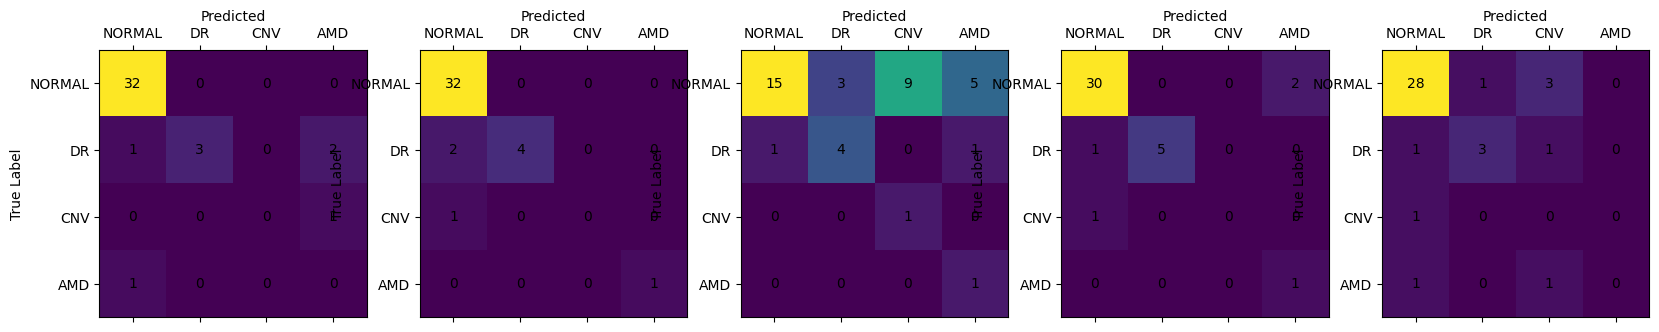

In [7]:
# selection of the features to use
num_features = data_list[0].x.shape[1]
num_classes = 4
epochs = 30

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax[i])



# 2 Class

In [8]:
y = [data.y for data in data_list_2cls]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 123456, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list_2cls)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list_2cls)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list_2cls):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

Split 1
Epoch: 001, Train Acc: 0.8500, Test Acc: 0.8750, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.1500, Test Acc: 0.1250, Test Bal Acc: 0.5000
Epoch: 003, Train Acc: 0.9187, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 004, Train Acc: 0.8875, Test Acc: 0.9500, Test Bal Acc: 0.9714
Epoch: 005, Train Acc: 0.9187, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 006, Train Acc: 0.6500, Test Acc: 0.6250, Test Bal Acc: 0.7857
Epoch: 007, Train Acc: 0.9375, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 008, Train Acc: 0.9125, Test Acc: 0.9500, Test Bal Acc: 0.8857
Epoch: 009, Train Acc: 0.9375, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 010, Train Acc: 0.8187, Test Acc: 0.8500, Test Bal Acc: 0.9143
Epoch: 011, Train Acc: 0.9375, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 012, Train Acc: 0.9125, Test Acc: 0.9750, Test Bal Acc: 0.9857
Epoch: 013, Train Acc: 0.9375, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 014, Train Acc: 0.9375, Test Acc: 0.9750, Test Bal Acc: 0.9000
Epoch: 015, 

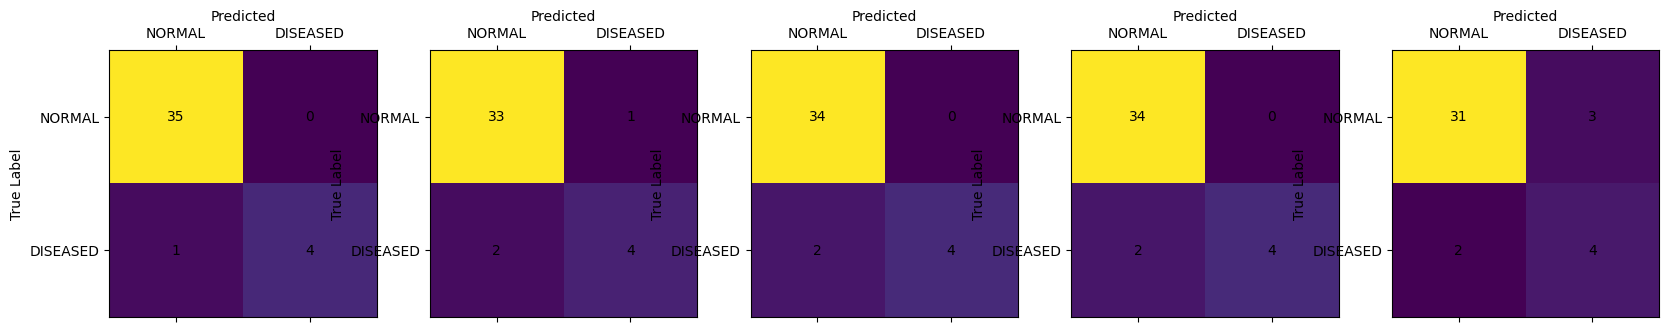

In [9]:
# selection of the features to use
num_features = data_list_2cls[0].x.shape[1]
num_classes = 2
epochs = 30

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)
    

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DISEASED"], ax[i])

# max test bal acc for each split [0.9714, 0.9020, 0.9167]

# 2 Class fitlered

In [5]:
y = [data.y for data in data_list_2cls_filt]

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 123456, shuffle= True)
skf.get_n_splits(np.arange(0, len(data_list_2cls_filt)), y)

splits = []
for train_idx, test_idx in skf.split(np.arange(0, len(data_list_2cls_filt)), y):
    train_list = []
    test_list = []
    for i, data in enumerate(data_list_2cls_filt):
        if i in train_idx:
            train_list.append(data)
        else:
            test_list.append(data)
    splits.append((train_list,test_list))

Split 1
Epoch: 001, Train Acc: 0.8477, Train Bal Acc: 0.5000, Test Acc: 0.8421, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.1523, Train Bal Acc: 0.5000, Test Acc: 0.1579, Test Bal Acc: 0.5000
Epoch: 003, Train Acc: 0.8477, Train Bal Acc: 0.5000, Test Acc: 0.8421, Test Bal Acc: 0.5000
Epoch: 004, Train Acc: 0.6755, Train Bal Acc: 0.7729, Test Acc: 0.6053, Test Bal Acc: 0.6979
Epoch: 005, Train Acc: 0.9536, Train Bal Acc: 0.8478, Test Acc: 0.8947, Test Bal Acc: 0.6667
Epoch: 006, Train Acc: 0.7417, Train Bal Acc: 0.8120, Test Acc: 0.6316, Test Bal Acc: 0.7135
Epoch: 007, Train Acc: 0.9536, Train Bal Acc: 0.8478, Test Acc: 0.8947, Test Bal Acc: 0.6667
Epoch: 008, Train Acc: 0.9272, Train Bal Acc: 0.9214, Test Acc: 0.7632, Test Bal Acc: 0.6562
Epoch: 009, Train Acc: 0.9536, Train Bal Acc: 0.8657, Test Acc: 0.8947, Test Bal Acc: 0.6667
Epoch: 010, Train Acc: 0.9536, Train Bal Acc: 0.9192, Test Acc: 0.8421, Test Bal Acc: 0.7031
Epoch: 011, Train Acc: 0.9470, Train Bal Acc: 0.8796, Test Acc

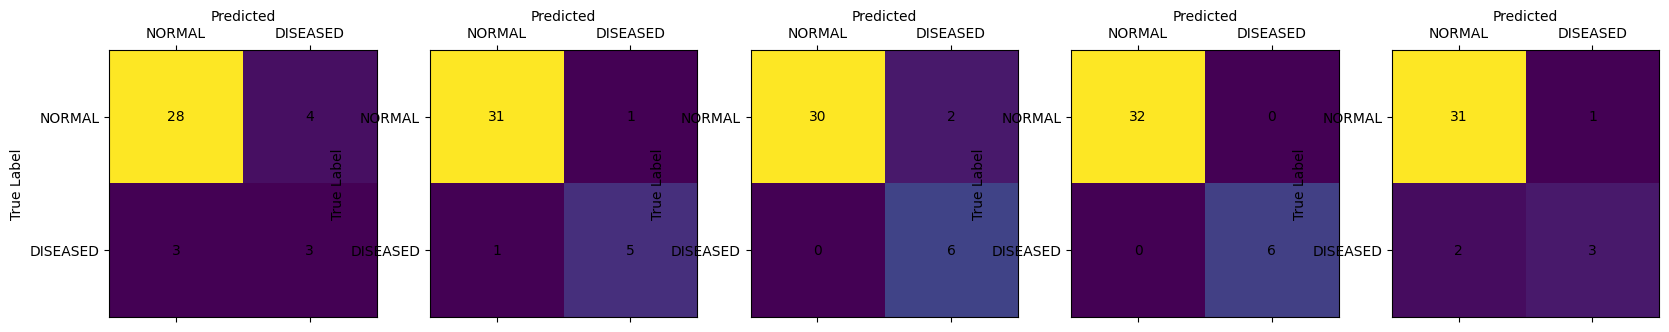

In [11]:
# selection of the features to use
num_features = data_list_2cls_filt[0].x.shape[1]
num_classes = 2
epochs = 30

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))

best_yt = []
best_yp = []

for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)

    prev_best = 0


    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p_test = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t_test = np.array([item.detach().numpy() for sublist in yList for item in sublist])

        outList, yList = classifier.predict(train_loader)
        y_p_train = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t_train = np.array([item.detach().numpy() for sublist in yList for item in sublist])

        train_bal_acc = balanced_accuracy_score(y_t_train, y_p_train)

        if epoch > 0 and train_bal_acc > prev_best:
            prev_best = train_bal_acc
            y_p_test_best = y_p_test
            y_t_test_best = y_t_test

        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Bal Acc: {train_bal_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t_test, y_p_test):.4f}')
    evaluation.plot_confusion_matrix(y_t_test_best, y_p_test_best, ["NORMAL", "DISEASED"], ax[i])
    best_yt.append(y_t_test_best)
    best_yp.append(y_p_test_best)


# first time maximal balanced training accuracy after 20 epochs
#Epoch: 025, Train Acc: 0.9603, Train Bal Acc: 0.9231, Test Acc: 0.9211, Test Bal Acc: 0.7500
#Epoch: 029, Train Acc: 0.9470, Train Bal Acc: 0.8796, Test Acc: 0.9474, Test Bal Acc: 0.9010
#Epoch: 024, Train Acc: 0.9338, Train Bal Acc: 0.8718, Test Acc: 0.9474, Test Bal Acc: 0.968
#Epoch: 024, Train Acc: 0.9272, Train Bal Acc: 0.8500, Test Acc: 1.0000, Test Bal Acc: 1.0000
#Epoch: 029, Train Acc: 0.9408, Train Bal Acc: 0.9141, Test Acc: 0.9189, Test Bal Acc: 0.7844

# training bal acc  [0.9231, 0.8796, 0.8718, 0.8500, 0.9141]
# epoch             [25, 29, 24, 24, 19]
# test bal acc      [0.7500, 0.9010, 0.968, 1.0000, 0.7844]
# test acc          [0.9211, 0.9474, 0.9474, 1.0000, 0.9189]



Split 1
Epoch: 001, Train Acc: 0.1523, Test Acc: 0.1579, Test Bal Acc: 0.5000
Epoch: 002, Train Acc: 0.8477, Test Acc: 0.8421, Test Bal Acc: 0.5000
Epoch: 003, Train Acc: 0.1523, Test Acc: 0.1579, Test Bal Acc: 0.5000
Epoch: 004, Train Acc: 0.9338, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 005, Train Acc: 0.9272, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 006, Train Acc: 0.9139, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 007, Train Acc: 0.9272, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 008, Train Acc: 0.9272, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 009, Train Acc: 0.9338, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 010, Train Acc: 0.8543, Test Acc: 0.9737, Test Bal Acc: 0.9844
Epoch: 011, Train Acc: 0.9404, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 012, Train Acc: 0.8411, Test Acc: 0.9737, Test Bal Acc: 0.9844
Epoch: 013, Train Acc: 0.9338, Test Acc: 0.9737, Test Bal Acc: 0.9167
Epoch: 014, Train Acc: 0.9338, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 015, 

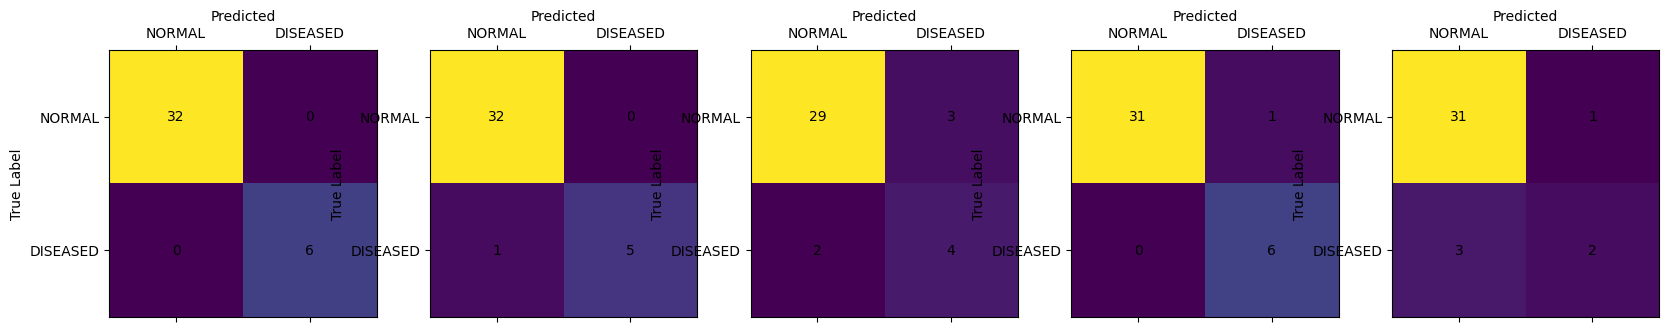

In [ ]:
# selection of the features to use
num_features = data_list_2cls_filt[0].x.shape[1]
num_classes = 2
epochs = 100

# try different aggregation modes:
# other aggragtion schemas not supported for batches

fig, ax = plt.subplots(1,5, figsize=(20,4))


for i, split in enumerate(splits):
    # create the model
    model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

    # create brach data loaders for training and test set
    train_loader = DataLoader(split[0], batch_size = 32, shuffle=True)
    test_loader = DataLoader(split[1], batch_size = 32, shuffle=False)

    # weigthings for imbalanced classes 
    train_labels = [lab["y"] for lab in split[0]]
    weights = 1/np.unique(train_labels, return_counts= True)[1]
    balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())

    classifier = graph_classifier.graphClassifierBatch(model, train_loader, test_loader, balanced_loss)

    print("Split " + str(i+1))
    for epoch in range(1, epochs+1):
        classifier.train()
        train_acc = classifier.test(train_loader)
        test_acc = classifier.test(test_loader)
        outList, yList = classifier.predict(test_loader)
        y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
        y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')
    evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DISEASED"], ax[i])



In [13]:
splits_train_bal_acc =[0.9231, 0.8796, 0.8718, 0.8500, 0.9141]
splits_epoch = [25, 29, 24, 24, 19]
splits_test_bal_acc =[0.7500, 0.9010, 0.968, 1.0000, 0.7844]
splits_test_acc = [0.9211, 0.9474, 0.9474, 1.0000, 0.9189]

In [18]:
print("Test set balanced accuracy")
print(f"Mean: {np.mean(splits_test_bal_acc):.4f}")
print(f"SD: {np.std(splits_test_bal_acc):.4f}")

print("Test set accuracy")
print(f"Mean: {np.mean(splits_test_acc):.4f}")
print(f"SD: {np.std(splits_test_acc):.4f}")

print("Train set balanced accuracy")
print(f"Mean: {np.mean(splits_train_bal_acc):.4f}")
print(f"SD: {np.std(splits_train_bal_acc):.4f}")

Test set balanced accuracy
Mean: 0.8807
SD: 0.0986
Test set accuracy
Mean: 0.9470
SD: 0.0292
Train set balanced accuracy
Mean: 0.8877
SD: 0.0272
